In [1]:
import pdb
import numpy as np
import os

from os.path import join
import matplotlib.pyplot as plt
from mayavi import mlab

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.tensorboard import SummaryWriter
import segyio

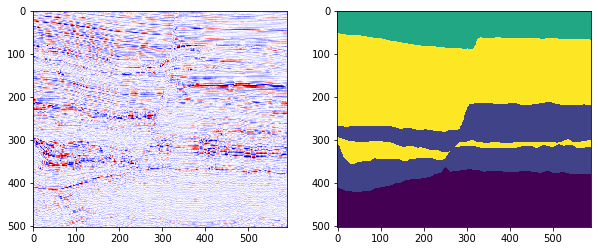

Mean: 0.6758
Standard Deviation: 390.3154
Maximum: 5088.9844
Minimum: -5195.5234
Unique Labels: [1. 2. 3. 4. 5. 6.]


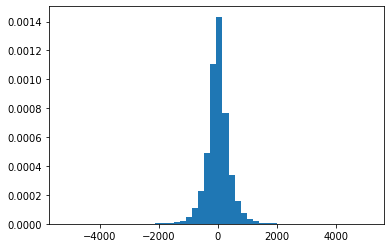

In [2]:
# Obtain paths for training data and labels
working_directory = os.getcwd()  # Get working directory
training_data_path= join(working_directory,'data', 'training_data.npy')
training_label_path = join(working_directory,'data','training_labels.npy')

# load the data
seismic = np.load(training_data_path)[:,:,::2] # shape (401 crosslines x 701 inlines x 255 depth samples)
labels = np.load(training_label_path)[:,:,::2]# same shape as seismic cube

# Visualize the section and labels
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,20))
ax1.imshow(seismic[:,0,:].T, cmap='seismic')
ax2.imshow(labels[:,0,:].T, vmin=1, vmax=6)
plt.show()

# Print data metrics
print('Mean: {:0.4f}'.format(seismic.mean()))
print('Standard Deviation: {:0.4f}'.format(seismic.std()))
print('Maximum: {:0.4f}'.format(seismic.max()))
print('Minimum: {:0.4f}'.format(seismic.min()))
print('Unique Labels: {}'.format(np.unique(labels)))

# Plot histogram of seismic amplitude values
plt.hist(seismic.flatten(), bins=50, density=True)
plt.show()


In [ ]:
  
fig1 = mlab.figure(figure='seismic', bgcolor=(1,1,1), fgcolor=(0,0,0))
scalars = seismic
mlab.volume_slice(scalars, slice_index=0, plane_orientation='x_axes', colormap='gray', figure=fig1)
mlab.volume_slice(scalars, slice_index=0, plane_orientation='y_axes', colormap='gray', figure=fig1)
mlab.volume_slice(scalars, slice_index=0, plane_orientation='z_axes', colormap='gray', figure=fig1)
mlab.outline()
mlab.axes(xlabel='Inline', ylabel='Crossline', zlabel='Depth', nb_labels=10)
mlab.show()

fig2 = mlab.figure(figure='labels', bgcolor=(1,1,1), fgcolor=(0,0,0))
scalars = labels
mlab.volume_slice(scalars, slice_index=0, plane_orientation='x_axes', figure=fig2)
mlab.volume_slice(scalars, slice_index=0, plane_orientation='y_axes', figure=fig2)
mlab.volume_slice(scalars, slice_index=0, plane_orientation='z_axes', figure=fig2)
mlab.outline()
mlab.axes(xlabel='Inline', ylabel='Crossline', zlabel='Depth', nb_labels=10)
mlab.show()

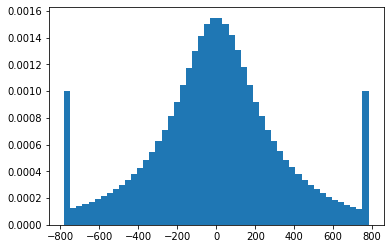

min:-779.9550170898438
max:781.3067016601562
Mean: 0.5000
Standard Deviation: 0.2159
Maximum: 1.0000
Minimum: 0.0000


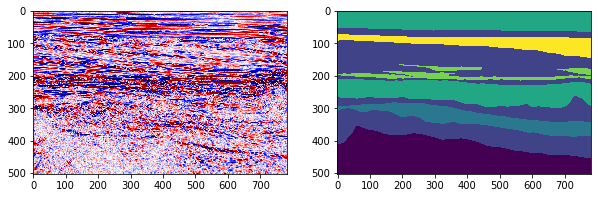

In [3]:
# Clip amplitudes to within one standard deviation of the mean
a_min = seismic.mean() - 2*seismic.std()
a_max = seismic.mean() + 2*seismic.std()
np.clip(seismic, a_min=a_min, a_max=a_max, out=seismic)
plt.hist(seismic.flatten(), bins=50, density=True)
plt.show()
print('min:{}'.format(seismic.min()))
print('max:{}'.format(seismic.max()))

# normalize
seismic = (seismic - seismic.min()) / (seismic.max() - seismic.min())
#seismic = (seismic - seismic.mean()) / seismic.std()

# bring labels into desired range for NLLL loss 
labels = labels - 1

# Print statistics for standardized data
print('Mean: {:0.4f}'.format(seismic.mean()))
print('Standard Deviation: {:0.4f}'.format(seismic.std()))
print('Maximum: {:0.4f}'.format(seismic.max()))
print('Minimum: {:0.4f}'.format(seismic.min()))

# Visualize the section and labels
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,20))
ax1.imshow(seismic[0].T, cmap='seismic')
ax2.imshow(labels[0].T)
plt.show()

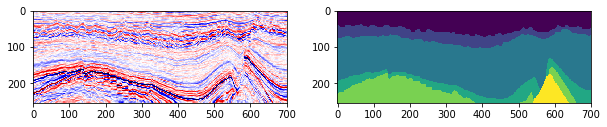

Mean: 0.0010
Standard Deviation: 0.2098
Maximum: 1.0000
Minimum: -1.0000
Unique Labels: [0 1 2 3 4 5]


In [2]:
# Obtain paths for training data and labels
working_directory = os.getcwd()  # Get working directory
training_data_path= join(working_directory,'data','train','train_seismic.npy')
training_label_path = join(working_directory,'data','train','train_labels.npy')

# load the data
seismic = np.load(training_data_path)  # shape (401 crosslines x 701 inlines x 255 depth samples)
labels = np.load(training_label_path) # same shape as seismic cube

# Visualize the section and labels
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,20))
ax1.imshow(seismic[0].T, cmap='seismic')
ax2.imshow(labels[0].T)
plt.show()

# Print data metrics
print('Mean: {:0.4f}'.format(seismic.mean()))
print('Standard Deviation: {:0.4f}'.format(seismic.std()))
print('Maximum: {:0.4f}'.format(seismic.max()))
print('Minimum: {:0.4f}'.format(seismic.min()))
print('Unique Labels: {}'.format(np.unique(labels)))

In [3]:
# normalize
seismic = (seismic - seismic.min()) / (seismic.max() - seismic.min())

# standardize
#seismic = (seismic - seismic.mean()) / seismic.std()

# Print statistics for standardized data
print('Mean: {:0.4f}'.format(seismic.mean()))
print('Standard Deviation: {:0.4f}'.format(seismic.std()))
print('Maximum: {:0.4f}'.format(seismic.max()))
print('Minimum: {:0.4f}'.format(seismic.min()))


Mean: 0.5005
Standard Deviation: 0.1049
Maximum: 1.0000
Minimum: 0.0000


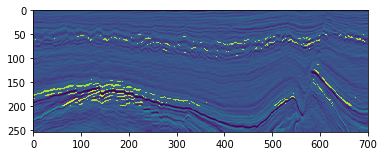

In [12]:
img = seismic[0].T
lbl = np.abs(img)
ind = np.indices((img.shape[0], img.shape[1]))
mask1 = (ind[0] > 50) * (ind[0] < 200)
mask2 = lbl>0.7
mask = mask1*mask2
lbl[mask] = 1
lbl[~mask] = 0

alpha = 0.5

blend = alpha*img + (1-alpha)*lbl

plt.imshow(blend)
plt.show()

# plt.imshow(seismic[350].T, cmap='seismic')
# plt.show()

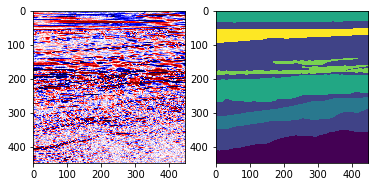

In [4]:
def image_crop(Im, height, width):
    """Generate 10 different versions of image crops of a given seismic section
    
    Parameters
    ----------
    Im: ndarray
       2D ndarray representing the seismic section desired to be cropped.
    
    height: int
          An integer specifying the height of the cropped sections
    
    width: int
         An integer specifying the width of the cropped sections         
       
    Returns
    -------
    images: tuple
          A tuple of ndarrays representing crops is returned in this order: top-left,
           top-right, bottom-left, bottom-right, center, and then the 5 horizontally flipped versions"""
    
    # Obtain corner crops
    top_left = Im[:height, :width]
    top_right = Im[:height, -width:]
    bottom_left = Im[-height:, :width]
    bottom_right = Im[-height:, -width:]
    
    # Obtain the center crop
    Im_h, Im_w = Im.shape
    start_height = Im_h//2 - height//2
    start_width = Im_w//2 - width//2
    center = Im[start_height:start_height+height, start_width:start_width+width]
    
    # Obtain the horizontally flipped versions
    im_list = [top_left, top_right, bottom_left, bottom_right, center]
    im_list_copy = [np.copy(im) for im in im_list]
    im_list_flipped = [np.flip(im, axis=1) for im in im_list_copy]
    images = im_list + im_list_flipped
    
    return images
    

# Visualizing crops for a given section

section = seismic[0].T  # Obtain seismic
label = labels[0].T  # Obtain corresponding label

# Obtain augmented images and labels. Crop size for parihaka dataset was 400
aug_images = image_crop(section, 448, 448)
aug_labels = image_crop(label, 448, 448)

crop_number = 9  # Integer from 0 to 9 specifying type of crop from original section
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(aug_images[crop_number], cmap='seismic')
ax2.imshow(aug_labels[crop_number])
fig.savefig('seismic_patch.png')
plt.show()

In [5]:
from torch.utils.data import Dataset, DataLoader
import torch

class F3SeismicPatch(Dataset):
    """Dataset class for loading F3 patches and labels"""
    
    def __init__(self, seismic_cube, label_cube, orientation, crop_size, num_sections):
        """Initializer function for the dataset class
        
        Parameters
        ----------
        seismic_cube: ndarray, (crosslines, inline, depth)
                    3D ndarray of floats representing seismic amplitudes
                    
        label_cube: ndarray, shape (crosslines, inline, depth)
                 3D ndarray same dimensions as seismic_cube containing label information.
                 Each value is [0,num_classes]
                    
        orientation: {'inline', 'crossline}, 
                  a string denoting the orientation of the seismic cube     
                  
        crop_size: int
                 Integer specifying crop size in seismic section    
                 
        num_sections: int
                    Integer specifying the number of sections to train on                       
        """
        
        self.seismic = seismic_cube
        self.label = label_cube
        assert orientation in ['inline', 'xline'], "Invalid Orientation Type! Please choose either of 'inline' and 'xline'."
        self.orientation = orientation
        self.crop_size = crop_size
        
        if self.orientation == 'xline':
            assert 0 < num_sections and num_sections <= seismic_cube.shape[0], "Number of sections exceeds number of crosslines in seismic cube"
        else:
            assert 0 < num_sections and num_sections <= seismic_cube.shape[1], "Number of sections exceeds number of inlines in seismic cube"
            
        self.num_sections = num_sections
     
    def __getitem__(self, index):
        """Obtains the image crops relating to each section in the given orientation.
        
        Parameters
        ----------
        index: int
             Integer specifies the section number along the given orientation.
             
        Returns
        -------
        images: ndarray of shape (10, H, W)
              Returns an ndarray of 10 image crops in the section specified by index"""
        
        section = self.seismic[index].T if self.orientation == 'xline' else self.seismic[:, index, :].T
        label_section = self.label[index].T if self.orientation == 'xline' else self.label[:, index, :].T
        img_crops = image_crop(section, self.crop_size, self.crop_size)
        label_crops = image_crop(label_section, self.crop_size, self.crop_size)
        
        seismic_patches = np.zeros((len(img_crops), self.crop_size, self.crop_size))
        label_patches = np.zeros((len(img_crops), self.crop_size, self.crop_size))
        
        for i, (img, label) in enumerate(zip(img_crops, label_crops)):
            seismic_patches[i] = img
            label_patches[i] = label
            
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        
        seismic_patches = torch.from_numpy(seismic_patches).to(device).type(torch.float)
        label_patches = torch.from_numpy(label_patches).to(device).type(torch.long)
        
        return seismic_patches, label_patches
    
    
    def __len__(self):
        """Retrieves total number of training samples"""
        
        return self.num_sections
    

In [6]:
num_sections = 80  # num of sections in both crossline and xline orientations to train
patch_size = 448

# Train on crosslines
f3_train_dataset_xline = F3SeismicPatch(seismic[100::6], labels[100::6], 'xline', patch_size, num_sections=num_sections)
f3_train_loader_xline = DataLoader(f3_train_dataset_xline, batch_size=1)

# Train on inlines
f3_train_dataset_inline = F3SeismicPatch(seismic[:,100::8,:], labels[:,100::8,:], 'inline', patch_size, num_sections=num_sections)
f3_train_loader_inline = DataLoader(f3_train_dataset_inline, batch_size=1)

# Test on inlines
f3_val_dataset = F3SeismicPatch(seismic[:, 3:5, :], labels[:, 3:5, :], 'inline', patch_size, num_sections=1)
f3_val_loader = DataLoader(f3_val_dataset, batch_size=1)


In [ ]:
import torchvision
import torch.nn as nn
import torch.nn.functional as F

class FCN8s(nn.Module):
    def __init__(self, n_class=6):
        super(FCN8s, self).__init__()
        # conv1
        self.conv1_1 = nn.Conv2d(1, 64, 3, padding=100)
        self.relu1_1 = nn.ReLU(inplace=True)
        self.conv1_2 = nn.Conv2d(64, 64, 3, padding=1)
        self.relu1_2 = nn.ReLU(inplace=True)
        self.pool1 = nn.MaxPool2d(2, stride=2, ceil_mode=True)  # 1/2

        # conv2
        self.conv2_1 = nn.Conv2d(64, 128, 3, padding=1)
        self.relu2_1 = nn.ReLU(inplace=True)
        self.conv2_2 = nn.Conv2d(128, 128, 3, padding=1)
        self.relu2_2 = nn.ReLU(inplace=True)
        self.pool2 = nn.MaxPool2d(2, stride=2, ceil_mode=True)  # 1/4

        # conv3
        self.conv3_1 = nn.Conv2d(128, 256, 3, padding=1)
        self.relu3_1 = nn.ReLU(inplace=True)
        self.conv3_2 = nn.Conv2d(256, 256, 3, padding=1)
        self.relu3_2 = nn.ReLU(inplace=True)
        self.conv3_3 = nn.Conv2d(256, 256, 3, padding=1)
        self.relu3_3 = nn.ReLU(inplace=True)
        self.pool3 = nn.MaxPool2d(2, stride=2, ceil_mode=True)  # 1/8

        # conv4
        self.conv4_1 = nn.Conv2d(256, 512, 3, padding=1)
        self.relu4_1 = nn.ReLU(inplace=True)
        self.conv4_2 = nn.Conv2d(512, 512, 3, padding=1)
        self.relu4_2 = nn.ReLU(inplace=True)
        self.conv4_3 = nn.Conv2d(512, 512, 3, padding=1)
        self.relu4_3 = nn.ReLU(inplace=True)
        self.pool4 = nn.MaxPool2d(2, stride=2, ceil_mode=True)  # 1/16

        # conv5
        self.conv5_1 = nn.Conv2d(512, 512, 3, padding=1)
        self.relu5_1 = nn.ReLU(inplace=True)
        self.conv5_2 = nn.Conv2d(512, 512, 3, padding=1)
        self.relu5_2 = nn.ReLU(inplace=True)
        self.conv5_3 = nn.Conv2d(512, 512, 3, padding=1)
        self.relu5_3 = nn.ReLU(inplace=True)
        self.pool5 = nn.MaxPool2d(2, stride=2, ceil_mode=True)  # 1/32

        # fc6
        self.fc6 = nn.Conv2d(512, 4096, 7)
        self.relu6 = nn.ReLU(inplace=True)
        self.drop6 = nn.Dropout2d()

        # fc7
        self.fc7 = nn.Conv2d(4096, 4096, 1)
        self.relu7 = nn.ReLU(inplace=True)
        self.drop7 = nn.Dropout2d()

        self.score_fr = nn.Conv2d(4096, n_class, 1)
        self.score_pool3 = nn.Conv2d(256, n_class, 1)
        self.score_pool4 = nn.Conv2d(512, n_class, 1)

        self.upscore2 = nn.ConvTranspose2d(
            n_class, n_class, 4, stride=2, bias=False)
        self.upscore8 = nn.ConvTranspose2d(
            n_class, n_class, 16, stride=8, bias=False)
        self.upscore_pool4 = nn.ConvTranspose2d(
            n_class, n_class, 4, stride=2, bias=False)

    def forward(self, x):
        h = x
        h = self.relu1_1(self.conv1_1(h))
        h = self.relu1_2(self.conv1_2(h))
        h = self.pool1(h)

        h = self.relu2_1(self.conv2_1(h))
        h = self.relu2_2(self.conv2_2(h))
        h = self.pool2(h)

        h = self.relu3_1(self.conv3_1(h))
        h = self.relu3_2(self.conv3_2(h))
        h = self.relu3_3(self.conv3_3(h))
        h = self.pool3(h)
        pool3 = h  # 1/8

        h = self.relu4_1(self.conv4_1(h))
        h = self.relu4_2(self.conv4_2(h))
        h = self.relu4_3(self.conv4_3(h))
        h = self.pool4(h)
        pool4 = h  # 1/16

        h = self.relu5_1(self.conv5_1(h))
        h = self.relu5_2(self.conv5_2(h))
        h = self.relu5_3(self.conv5_3(h))
        h = self.pool5(h)

        h = self.relu6(self.fc6(h))
        h = self.drop6(h)

        h = self.relu7(self.fc7(h))
        h = self.drop7(h)

        h = self.score_fr(h)
        h = self.upscore2(h)
        upscore2 = h  # 1/16

        h = self.score_pool4(pool4)
        h = h[:, :, 5:5 + upscore2.size()[2], 5:5 + upscore2.size()[3]]
        score_pool4c = h  # 1/16

        h = upscore2 + score_pool4c  # 1/16
        h = self.upscore_pool4(h)
        upscore_pool4 = h  # 1/8

        h = self.score_pool3(pool3)
        h = h[:, :,
              9:9 + upscore_pool4.size()[2],
              9:9 + upscore_pool4.size()[3]]
        score_pool3c = h  # 1/8

        h = upscore_pool4 + score_pool3c  # 1/8

        h = self.upscore8(h)
        h = h[:, :, 31:31 + x.size()[2], 31:31 + x.size()[3]].contiguous()

        return h



In [7]:
import torch
import torch.nn as nn

def double_conv(in_channels, out_channels):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, 3, padding=1),
        nn.ReLU(inplace=True),
        nn.Conv2d(out_channels, out_channels, 3, padding=1),
        nn.ReLU(inplace=True)
    )   


class UNet(nn.Module):

    def __init__(self, n_class):
        super().__init__()
                
        self.dconv_down1 = double_conv(1, 4)
        self.dconv_down2 = double_conv(4, 4)
        self.dconv_down3 = double_conv(4, 8)
        self.dconv_down4 = double_conv(8, 8)
        self.dconv_down5 = double_conv(8, 12)
        self.dconv_down6 = double_conv(12, 16)
        self.dconv_down7 = double_conv(16, 16)

        self.maxpool = nn.MaxPool2d(2)
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)        
        
        self.dconv_up6 = double_conv(32, 16)
        self.dconv_up5 = double_conv(28, 8)
        self.dconv_up4 = double_conv(16, 8)
        self.dconv_up3 = double_conv(16, 8)
        self.dconv_up2 = double_conv(12, 8)
        self.dconv_up1 = double_conv(12, 8)
        
        self.conv_last = nn.Conv2d(8, n_class, 1)
        
        
    def forward(self, x):
        conv1 = self.dconv_down1(x)  # size is LxL
        x = self.maxpool(conv1)

        conv2 = self.dconv_down2(x)  # size is L/2 x L/2
        x = self.maxpool(conv2)
        
        conv3 = self.dconv_down3(x)  # size is L/4 x L/4
        x = self.maxpool(conv3)   
        
        conv4 = self.dconv_down4(x)  # size is L/8 x L/8
        x = self.maxpool(conv4)
        
        conv5 = self.dconv_down5(x)  # size is L/16 x L/16 
        x = self.maxpool(conv5)
        
        conv6 = self.dconv_down6(x)     # size is L/32 x L/32
        x = self.maxpool(conv6)
        
        x = self.dconv_down7(x)         # size is L/64 x L/64
                
        x = self.upsample(x)   
        x = torch.cat([x, conv6], dim=1)  # size is L/32 x L/32
        
        x = self.dconv_up6(x)  
        x = self.upsample(x)        
        x = torch.cat([x, conv5], dim=1)   # size is L/16 x L/16       

        x = self.dconv_up5(x)
        x = self.upsample(x)        
        x = torch.cat([x, conv4], dim=1)   # size is L/8 x L/8
        
        x = self.dconv_up4(x)
        x = self.upsample(x)        
        x = torch.cat([x, conv3], dim=1)   # size is L/4 x L/4

        x = self.dconv_up3(x)
        x = self.upsample(x)        
        x = torch.cat([x, conv2], dim=1)   # size is L/2 x L/2
        
        x = self.dconv_up2(x)
        x = self.upsample(x)        
        x = torch.cat([x, conv1], dim=1)   # size is L x L
        
        x = self.dconv_up1(x)
        
        out = self.conv_last(x)
        
        return out

In [ ]:
data = labels
label_value = 5
mask = data==label_value
label_fraction = mask.sum() / (labels.shape[0]*labels.shape[1]*labels.shape[2])
label_weight = 1 / label_fraction
print(label_fraction, label_weight)
# weight tensor for parihaka = [6, 2.4, 24, 3.5, 30, 11]

In [ ]:
writer = SummaryWriter(join(working_directory,'runs', 'exp_23_Parihaka_even_dataset_division_80samples_reweightedloss_14layer_Unet'))

# Initialize model and send to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNet(n_class=6).to(device)

# Define weights for different classes
weight=torch.tensor([6, 2.4, 24, 3.5, 30, 11], dtype=torch.float).to(device)
criterion = nn.CrossEntropyLoss(weight=weight) # Set up criterion

optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)

num_epochs = 20
batch_size = 1
total_batches = np.ceil(10/batch_size).astype(int)

prev_loss = torch.tensor(10000, dtype=torch.float, requires_grad=False)  # initial validation loss benchmark
for epoch in range(num_epochs):
    # start training
    for iteration, ((imgs_xline, lbls_xline), (imgs_inline, lbls_inline)) in enumerate(zip(f3_train_loader_xline, f3_train_loader_inline)):
        imgs_xline.transpose_(0,1)
        lbls_xline = lbls_xline.squeeze()
        imgs_inline.transpose_(0,1)
        lbls_inline = lbls_inline.squeeze()
        start_i = 0  # index of starting training samples
        for batch_number in range(total_batches):    
            model.train()
            optimizer.zero_grad()
            
            out_xline = model(imgs_xline[start_i:start_i+batch_size])
            out_inline = model(imgs_inline[start_i:start_i+batch_size])

            loss_train_xline = criterion(out_xline, lbls_xline[start_i:start_i+batch_size]) / total_batches            
            loss_train_inline = criterion(out_inline, lbls_inline[start_i:start_i+batch_size])/ total_batches
    
            loss_train_xline.backward()
            loss_train_inline.backward()
            
            optimizer.step()
            start_i += batch_size
            
        if iteration % 15 == 0:
                # Test on validation
                with torch.no_grad():
                    model.eval()
                    for imgs, lbls in f3_val_loader:
                          out = model(imgs.transpose_(0, 1)[:5])
                          val_loss = criterion(out, lbls.squeeze()[:5])
                          fig, (ax1, ax2) = plt.subplots(1, 2)
                          ax1.imshow(out.argmax(dim=1)[0].detach().cpu().numpy(), vmin=labels.min(), vmax=labels.max())
                          ax2.imshow(lbls.squeeze()[0].detach().cpu().numpy(), vmin=labels.min(), vmax=labels.max())
                          writer.add_figure('Val_patch_0', fig, global_step=epoch*num_sections+iteration, close=True)
                          if val_loss.item() < prev_loss:
                              torch.save(model.state_dict(), join(working_directory,'best_val_model.pth'))
                              prev_loss = val_loss.item()
        
        writer.add_scalar('Loss/train', loss_train_inline.item()+loss_train_xline.item(), epoch*num_sections+iteration)                
        writer.add_scalar('Loss/val', val_loss.item(), epoch*num_sections+iteration)    
        print('Epoch: {} | Iteration: {} | Train Loss: {:0.4f} | Val Loss: {:0.4f}'.format(epoch,
                                                                                           iteration,
                                                                                           loss_train_inline.item()+
                                                                                           loss_train_xline.item(),
                                                                                           val_loss.item()))
            
    

In [ ]:

model = FCN8s().to(device)
model.load_state_dict(torch.load(join(working_directory, 'best_val_model.pth')))

with torch.no_grad():
    model.eval()
    for imgs, lbls in f3_val_loader:
        out = model(imgs.transpose_(0, 1)[:5])
        
pred = out.argmax(dim=1).detach().cpu().numpy().astype(int)
lbls = lbls.squeeze().detach().cpu().numpy().astype(int)

fig, axs = plt.subplots(lbls.shape[0], 2, sharey=True, figsize=(20, 20))

for i in range(lbls.shape[0]):
    axs[i,0].imshow(pred[i], vmin=0, vmax=5)
    axs[i,1].imshow(lbls[i], vmin=0, vmax=5)


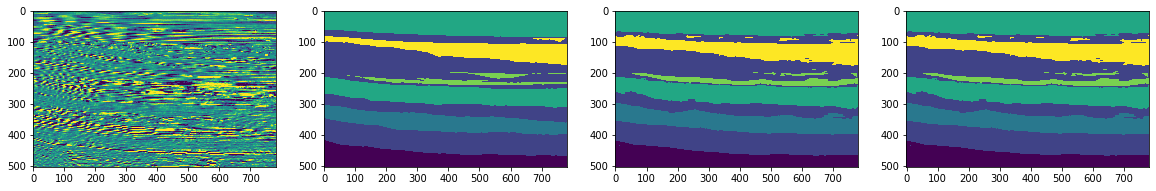

In [8]:
def section_predict(model, section, patch_length):
    """Function evaluates the given segmentation model on the complete
    seismic section.
    
    Paramters
    ---------   
    model: torch.nn.module object.
         The trained segmentation model to be applied. Model assumed to be on GPU
         
    section: torch.tensor of shape (depth, width)
         A 2D tensor representing the section to apply the model on. Also assumed to be GPU
         
    patch_length: int
                Length of patches model was trained on     
         
    Returns
    -------
    segmented_section: ndarray
                     A 2D ndarray corresponding to the segmented seismic section input
                     to the function."""
    
    height, width = section.shape
    row_strides = np.ceil(height / patch_length).astype(int)  # Full column strides a kernel of patch_length can make in the section
    column_strides = np.ceil(width / patch_length).astype(int)  # Full row strides a kernel of patch_length can make in the section
    
    segmented_section = torch.randn(section.shape[0], section.shape[1]).cuda().float()
    
    for row_stride in range(row_strides):
        for column_stride in range(column_strides):
            
            if column_stride+1 > width/patch_length:
                start_column_index = -patch_length
                end_column_index = None
            else:
                start_column_index = patch_length*column_stride
                end_column_index = patch_length*(column_stride+1)
            
            if row_stride+1 > height/patch_length:
                start_row_index = -patch_length
                end_row_index = None
            else:
                start_row_index = patch_length*row_stride    
                end_row_index = patch_length*(row_stride+1)
                
            section_patch = section[start_row_index:end_row_index, start_column_index:end_column_index]
            with torch.no_grad():
                segmented_patch = model(section_patch.unsqueeze(0).unsqueeze(0)).argmax(dim=1).squeeze()
                                      
            segmented_section[start_row_index:end_row_index, start_column_index:end_column_index] = segmented_patch
    
    return segmented_section
 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNet(n_class=6).to(device)
model.load_state_dict(torch.load(join(working_directory, 'best_val_model.pth'))) 
 
section_num = 80
test_section = torch.from_numpy(seismic[section_num].T).cuda().float()
predicted_section = section_predict(model, test_section, patch_size)
label_section = labels[section_num].T
#predicted_section_full = model(test_section[None, None, :, :]).argmax(dim=1).squeeze()
predicted_section_full = predicted_section

fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(20,20))

ax1.imshow(test_section.detach().cpu())
ax2.imshow(label_section, vmin=0, vmax=5)
ax3.imshow(predicted_section.detach().cpu(), vmin=0, vmax=5)
ax4.imshow(predicted_section_full.detach().cpu(), vmin=0, vmax=5)

fig.savefig('predicted_2d.png')
plt.show()

In [ ]:
from sklearn.metrics import jaccard_score
from sklearn.metrics import accuracy_score

def compute_labels(data, model, patch_size, orientation ='crossline'):
    """computed mIOU and mPA for segmentation accuracy
    
    Parameters
    ----------
    data: ndarray, 3D
        3D array of data of dimensions (Crossline x Inlines x Depth). The segmentation
        labels will be evaluated for each of the 2D Inlines x Depth section. It is the
        user's responsibility to input data in the orientaion segmentations are desired
        to be estimated.
        
    model: a PyTorch nn.modules object
        A trained segmentation model on cuda 
        
    patch_size: int
        integer specifying patch size of for model estimations    
        
            
    orientation: str, optional
               Specifes the orientation of the datacube. Assumes crossline by default. 
               If inline, it transposes the first 2 axes of data.       
        
    Returns
    -------
    label_volume: ndarray, 3D
                Volume of labels. Same shape as data   
        """
    
    assert orientation in ['crossline', 'inline'], "Please specify the correct data cube orientation"
    
    # create a label volume of the same dimensions as the seismic data cube itself
    device = torch.device("cuda")
    label_volume = torch.zeros(data.shape, dtype=torch.float).to(device)
    
    num_sections = data.shape[0] if orientation=='crossline' else data.shape[1]
    
    for section_num in range(num_sections):
        with torch.no_grad():
             if orientation == 'crossline':
                section = torch.from_numpy(data[section_num].T).cuda().float() # obtain section and convert to torch.float tensor on cuda
                label_volume[section_num] = section_predict(model, section, patch_size).T
             
             else:
                section = torch.from_numpy(data[:,section_num,:].T).cuda().float() # obtain section and convert to torch.float tensor on cuda 
                label_volume[:, section_num, :] = section_predict(model, section, patch_size).T
    
    return label_volume.detach().cpu().numpy()        
       

pred_label_volume_iline = compute_labels(seismic, model, patch_size=patch_size, orientation='crossline')      
pred_label_volume_xline = compute_labels(seismic, model, patch_size=patch_size, orientation='inline')

# print statistics for test 1
IOU = jaccard_score(labels[:100].flatten(), pred_label_volume_iline[:100].flatten(), labels=list(range(6)), average=None)
mPA = accuracy_score(labels[:100].flatten(), pred_label_volume_iline[:100].flatten())
print("IOU per class: ", IOU)
print("Test1 mIOU: {:0.4f}".format(IOU.mean()))
print("Test1 mPA: {:0.4f}".format(mPA))

# print statistics for test 2
IOU = jaccard_score(labels[:,1:100,:].flatten(), pred_label_volume_xline[:,1:100,:].flatten(), labels=list(range(6)), average=None)
mPA = accuracy_score(labels[:,1:100,:].flatten(), pred_label_volume_xline[:,1:100,:].flatten())
print("IOU per class: ", IOU)
print("Test2 mIOU: {:0.4f}".format(IOU.mean()))
print("Test2 mPA: {:0.4f}".format(mPA))


In [ ]:
fig2 = mlab.figure(figure='labels', bgcolor=(1,1,1), fgcolor=(0,0,0))
pred_label_volume_iline[0,0] = 5
#scalars = pred_label_volume_iline
scalars=labels
#mlab.contour3d(scalars, contours=[2])
obj = mlab.volume_slice(scalars, slice_index=0, plane_orientation='x_axes', figure=fig2)
mlab.volume_slice(scalars, slice_index=0, plane_orientation='y_axes', figure=fig2)
mlab.volume_slice(scalars, slice_index=0, plane_orientation='z_axes', figure=fig2)
mlab.outline()
mlab.axes(xlabel='Inline', ylabel='Crossline', zlabel='Depth', nb_labels=10)
mlab.show()


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set()

num_slices = 2*np.array([5, 10, 15, 20, 40, 80])
data_fraction = num_slices/1100
m_ious = np.array([0.34, 0.32, 0.53, 0.63, 0.86, 0.88])
m_pas = np.array([0.69, 0.66, 0.83, 0.93, 0.96, 0.97])

fig, ax = plt.subplots()
ax.plot(data_fraction, m_ious, marker='x', color='b', label='Mean IOU')
ax.plot(data_fraction, m_pas, marker='o', color='r', label='Pixel Accuracy')
ax.set_xlabel('Fraction of labeled Training data')
plt.legend()
fig.savefig('richness_data.png')
plt.show()

In [9]:
working_directory = os.getcwd()
test1_path = join(working_directory, 'data', 'TestData_Image1.npy')
test2_path = join(working_directory, 'data', 'TestData_Image2.npy')

test_seismic1 = np.load(test1_path)[:, :, ::2]
test_seismic2 = np.load(test2_path)[:, :, ::2]

In [10]:
def seismic_normalize(data, num_stds):
    '''normalizes seismic data volume between mean - num_std*std to mean + num_std*std before finally
    standardizing between 0 and 1'''
    
    mean = data.mean()
    std = data.std()
    
    data = np.clip(data, a_min=mean-num_stds*std, a_max=mean+num_stds*std)
    data = (data - data.min()) / (data.max() - data.min())
    
    return data 

x1 = seismic_normalize(test_seismic1, 2)
x2 = seismic_normalize(test_seismic2, 2)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNet(n_class=6).to(device)
model.load_state_dict(torch.load(join(working_directory, 'best_val_model.pth'))) 

test1_labels = compute_labels(x1, model, 448, orientation='crossline')
test2_labels = compute_labels(x2, model, 448, orientation='inline')

In [ ]:
fig1 = mlab.figure(figure='seismic', bgcolor=(1,1,1), fgcolor=(0,0,0))
scalars = test2_labels
mlab.volume_slice(scalars, slice_index=0, plane_orientation='x_axes', figure=fig1)
mlab.volume_slice(scalars, slice_index=0, plane_orientation='y_axes', figure=fig1)
mlab.volume_slice(scalars, slice_index=0, plane_orientation='z_axes', figure=fig1)
mlab.outline()
mlab.axes(xlabel='Inline', ylabel='Crossline', zlabel='Depth', nb_labels=10)
mlab.show()


